In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [2]:
import time
from tqdm import tqdm

In [3]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

from pycbc.waveform import get_td_waveform,td_taper,apply_fd_time_shift
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match,matched_filter
from pycbc.types import TimeSeries
import lal,sxs
from pycbc import conversions

# SXS catalog

In [4]:
class sxswave(object):
    '''
    A class to read SXS waveform
    At the moment only return h22 and sliced waveform 
    starting from the reference time
    '''
    def __init__(self,sxsid,ext_order=4):
        #load the data and metadata.json
        self.hlm = sxs.load("SXS:BBH:"+str(sxsid)+"/Lev/rhOverM", 
                            extrapolation_order=ext_order)
        self.metadata = sxs.load("SXS:BBH:"+str(sxsid)+
                                 "/Lev/metadata.json")

        # time slide the 0 time point to the maximum norm position
        # self.max_norm_time = self.hlm.max_norm_time()
        # AttributeError: can't set attribute
        
        # chop off the junk radiation
        t_start = self.metadata.reference_time
        i_start = self.hlm.index_closest_to(t_start)
        self.hlm_sliced = self.hlm[i_start:]
        
        # Only consider 22 mode at the moment
        self.h22 = self.hlm_sliced[:, self.hlm.index(2, 2)]
        
    def hphc(self,theta,phi):
        '''
        Evaluate h+ - ihx = hlm -2Ylm(theta,phi)
        '''
        return self.hlm_sliced.evaluate(theta, phi)
    
    def h22_pycbcts(self):
        '''
        h22
        '''
        t_start = self.h22.t[0]
        t_end = self.h22.t[-1]
        dt = np.max(np.diff(self.h22.t))
        #uniform time to interpolate
        t_uniform = np.arange(t_start, t_end, dt)
        h = self.h22.interpolate(t_uniform)
        return TimeSeries(h.data, delta_t = dt,
                          epoch = -dt * np.argmax(np.abs(h.data)))
    
    def hp_pycbcts_phyunit(self,**kwargs):
        '''
        
        '''
        mtotal = kwargs['mass1'] + kwargs['mass2']
        distance = kwargs['distance']
        amp_factor = distance*1e6*lal.PC_SI / mtotal /lal.MRSUN_SI
        time_factor = 1/ mtotal /lal.MTSUN_SI

        '''
        if dt / time_factor < kwargs['delta_t']:
            dt  = time_factor * kwargs['delta_t']
        else:
            raise ValueError("dt (in physics unit) larger than the delta_t required")
        '''
        h22 = self.h22_pycbcts()
        Y22 = lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)
        hplus = np.real( h22.data * Y22)
        dt = h22.delta_t
        return TimeSeries( hplus / amp_factor,delta_t = dt / time_factor,\
                          epoch = - dt * np.argmax(np.abs(hplus)) / time_factor)

In [5]:
def waveform_par(mtotal,nr_metadata,distance=100,eccentricity=0):
    '''
    Given a mtotal and nr_metadata, return waveform par to generate pycbc waveform
    or convert a NR waveform to phy unit
    '''
    q = nr_metadata['reference_mass_ratio']
    kwargs = {'mass1':conversions.mass1_from_mtotal_q(mtotal,q),
          'mass2':conversions.mass2_from_mtotal_q(mtotal,q),
          'spin1z':nr_metadata['reference_dimensionless_spin1'][2],
          'spin2z':nr_metadata['reference_dimensionless_spin2'][2],
          'distance':distance,
          'eccentricity':eccentricity
             }
    return kwargs

# NR waveform

In [6]:
nr_wf = sxswave(1362)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:1362v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1362v5/Lev5/metadata.json


# PyCBC match

In [7]:
def get_psd(seob,nr,start_frequency=20):
    if seob.duration != nr.duration:
        raise TypeError('Error: the waveforms have unequal duration!')
    delta_f = 1.0 / seob.duration
    tlen = len(seob)
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, start_frequency)
    return psd

In [17]:
def get_match(eccentricity,mtotal,nr_class,f_low=20,taper_offset=0.1):
    par = waveform_par(mtotal,nr_class.metadata)
    par.update({'eccentricity':eccentricity})
    
    nr_phy = nr_wf.hp_pycbcts_phyunit(**par)
    nr_taper = td_taper(nr_phy,nr_phy.start_time,nr_phy.start_time+taper_offset)
    
    dt = nr_taper.delta_t
    hp, _ = get_td_waveform(**par,
                                 approximant='SEOBNREHM',
                                 delta_t=dt,
                                 f_lower=f_low,is_only_22=1)
    seob_taper = td_taper(hp,hp.start_time,hp.start_time+taper_offset)
    
    tlen = max(len(seob_taper),len(nr_taper))
    seob_taper.resize(tlen)
    nr_taper.resize(tlen)
    psd = get_psd(seob_taper,nr_taper,f_low)
    m, _ = match(seob_taper, nr_taper, psd=psd, low_frequency_cutoff=f_low)
    return m

def validation(eccentricity,mtotal,nr_class,f_low=20,taper_offset=0.1):
    par = waveform_par(mtotal,nr_class.metadata)
    par.update({'eccentricity':eccentricity})
    
    nr_phy = nr_wf.hp_pycbcts_phyunit(**par)
    nr_taper = td_taper(nr_phy,nr_phy.start_time,nr_phy.start_time+taper_offset)
    
    dt = nr_taper.delta_t
    hp, _ = get_td_waveform(**par,
                                 approximant='SEOBNREHM',
                                 delta_t=dt,
                                 f_lower=f_low,is_only_22=1)
    seob_taper = td_taper(hp,hp.start_time,hp.start_time+taper_offset)
    
    tlen = max(len(seob_taper),len(nr_taper))
    seob_taper.resize(tlen)
    nr_taper.resize(tlen)
    psd = get_psd(seob_taper,nr_taper,f_low)
    #m, _ = match(seob_taper, nr_taper, psd=psd, low_frequency_cutoff=f_low)
    mf = matched_filter(seob_taper, nr_taper, psd=psd, low_frequency_cutoff=f_low)
    idx_max   = np.argmax(np.abs(mf))
    max_time  = mf.sample_times[idx_max] 
    max_phase = np.angle(mf[idx_max])
    hp_shift = seob_taper.copy()
    hp_shift = hp_shift.to_frequencyseries() * np.exp(1.0j*max_phase)
    hp_shift = apply_fd_time_shift(hp_shift, max_time, copy=True)
    hp_shift = hp_shift.to_timeseries()
    return hp_shift,nr_taper

In [9]:
mtotal = np.arange(40,100,5)
ecc_max = []
match_max = []

In [10]:
for m in mtotal:
    print(m)
    def f(e):
        return -get_match(e,m,nr_wf)
    res = minimize_scalar(f, bounds=(0, 0.4), method='bounded')
    ecc_max.append(res.x)
    match_max.append(-f(res.x))

40
45
50
55
60
65
70
75
80
85
90
95


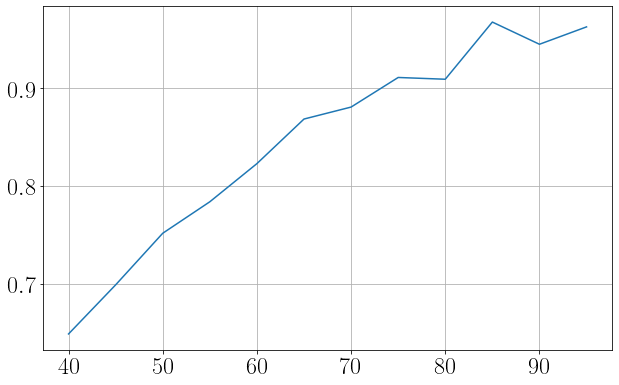

In [12]:
plt.plot(mtotal,match_max)

In [13]:
ecc_max

[0.15891407939203986,
 0.09498385243854415,
 0.2466664035295268,
 0.093441895565513,
 0.15353959306946466,
 0.24686110858715107,
 0.09883788377314462,
 0.1326919862807827,
 0.04988727272891544,
 0.2251494232126651,
 0.0634988244581137,
 0.08675991388133492]

In [14]:
mtotal[np.argmax(match_max)]

85

In [18]:
ii = np.argmax(match_max)
seob_valid,nr = validation(ecc_max[ii],mtotal[ii],nr_wf)

Text(0.5, 1.0, 'total mass:85 ecc:{0.23} match:{0.97}')

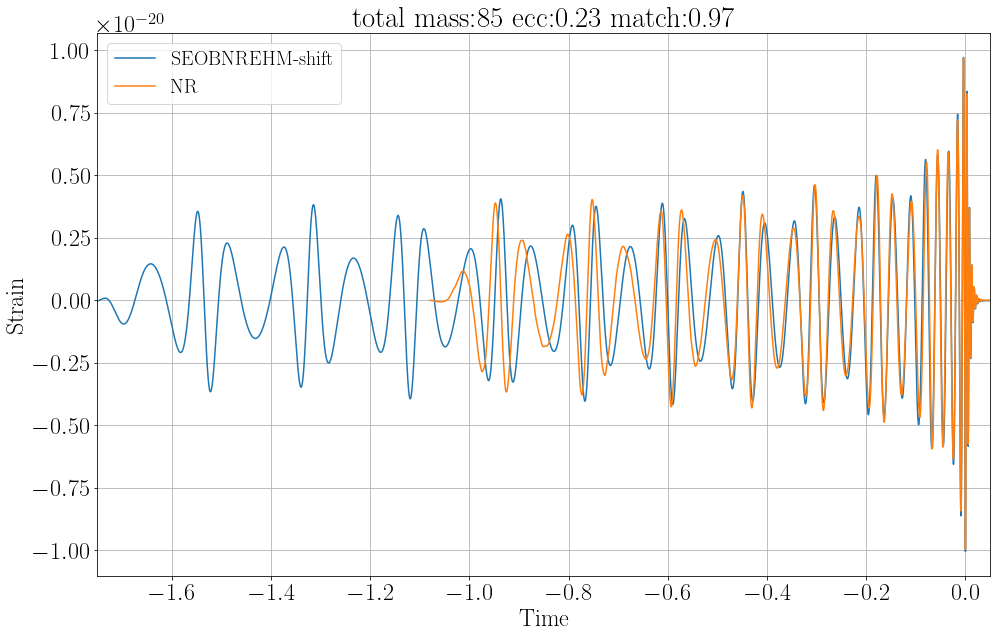

In [32]:
#plt.plot(hp.sample_times,hp,label='SEOBNREHM')
plt.figure(figsize=[16,10])
plt.plot(seob_valid.sample_times,seob_valid,label='SEOBNREHM-shift')
plt.plot(nr.sample_times,nr,label='NR')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.xlim(-1.75,0.05)
plt.legend()
plt.title('total mass:' +str(mtotal[ii])+' ecc:{%.2f}' % ecc_max[ii]+' match:{%.2f}' % np.max(match_max))

Text(0.5, 1.0, 'total mass:85 ecc:{0.23} match:{0.97}')

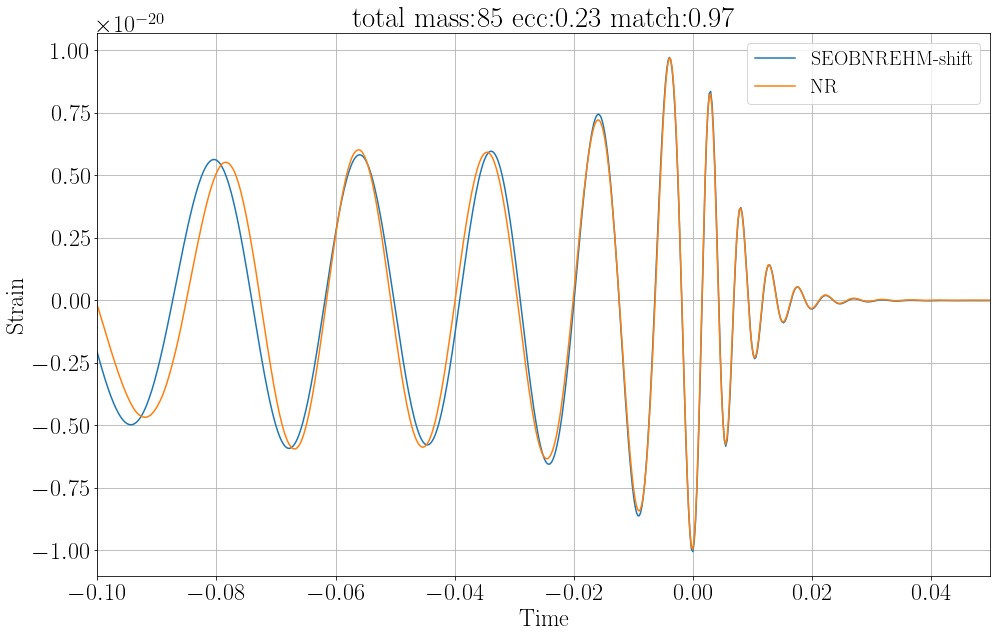

In [33]:
#plt.plot(hp.sample_times,hp,label='SEOBNREHM')
plt.figure(figsize=[16,10])
plt.plot(seob_valid.sample_times,seob_valid,label='SEOBNREHM-shift')
plt.plot(nr.sample_times,nr,label='NR')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.xlim(-0.1,0.05)
plt.legend()
plt.title('total mass:' +str(mtotal[ii])+' ecc:{%.2f}' % ecc_max[ii]+' match:{%.2f}' % np.max(match_max))